In [2]:
import os

data_dir = 'data'
filename = 'jena_climate_2009_2016.csv'

with open( os.path.join(data_dir, filename), 'r' ) as f:
  data = f.read()
  
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print('Header: {}'.format(header))
print('Number of records in data: {}'.format(len(lines)))

Header: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Number of records in data: 420551


In [3]:
import numpy as np

data = np.zeros( (len(lines), len(header)-1) )
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  data[i, :] = values

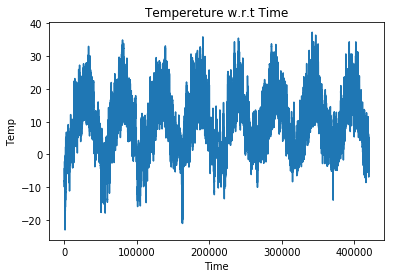

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

num_records = len(lines)
temp = data[:, 1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( range(num_records), temp )
ax.set_title('Tempereture w.r.t Time')
ax.set_xlabel('Time')
ax.set_ylabel('Temp')

plt.show()

In [5]:
data = data - data.mean(axis=0)
data = data / data.std(axis=0)

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, 
              batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  
  while True:
    if shuffle:
      rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i+batch_size, max_index))
      i += len(rows)
      
    samples = np.zeros( (len(rows), lookback//step, data.shape[-1]) )
    targets = np.zeros( (len(rows), ) )
    
    for j, row in enumerate(rows):
      indices = range(rows[j]-lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [8]:
train_gen = generator(data, lookback=lookback, delay=delay, min_index=0,
                      max_index=200000, shuffle=True, step=step, batch_size=batch_size)

valid_gen = generator(data, lookback=lookback, delay=delay, min_index=200001, 
                     max_index=300000, shuffle=True, step=step, batch_size=batch_size)

test_gen = generator(data, lookback=lookback, delay=delay, min_index=300001, 
                    max_index=None, shuffle=False, step=step, batch_size=batch_size)

Establishing a baseline, compared to which the deep learning models will be implemented

In [ ]:
# Predicting temp 24 hours later to be the same as today's temperature

val_steps = (300000 - 200001 - lookback)
test_steps = (len(data) - 300001 - lookback)

def evaluate_naive_method():
  mean_absolute_errors = []
  for step in range(val_steps):
    samples, targets = next(valid_gen)
    predictions = samples[:, -1, 1]
    mae = np.mean( np.abs(predictions - targets) )
    mean_absolute_errors.append(mae)
    
  print(np.mean( mean_absolute_errors ))
  
evaluate_naive_method()

In [36]:
# Using simple densely connected feed-forward neural net
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
model.add( Flatten( input_shape=(lookback // step, data.shape[-1]) ) )
model.add( Dense(32, activation='relu') )
model.add( Dense(32, activation='relu') )
model.add( Dense(1) )
print(model.summary())

model.compile(optimizer='rmsprop', loss='mae')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                107552    
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 108,641
Trainable params: 108,641
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
history = model.fit_generator(train_gen, steps_per_epoch=1000, epochs=20,
                              validation_data=valid_gen, validation_steps=1000)

Epoch 1/20
1000/1000 [==============================] - 27s 27ms/step - loss: 0.4230 - val_loss: 0.3647
Epoch 2/20
1000/1000 [==============================] - 27s 27ms/step - loss: 0.3145 - val_loss: 0.3706
Epoch 3/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.2868 - val_loss: 0.3742
Epoch 4/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.2679 - val_loss: 0.4197
Epoch 5/20
1000/1000 [==============================] - 27s 27ms/step - loss: 0.2541 - val_loss: 0.3871
Epoch 6/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.2432 - val_loss: 0.3736
Epoch 7/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.2341 - val_loss: 0.3776
Epoch 8/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.2279 - val_loss: 0.3802
Epoch 9/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.2217 - val_loss: 0.3941
Epoch 10/20
1000/1000 [==============================] - 26s 26m

In [0]:
filename = 'temperature_prediction_feedforward.h5'

models_dir = 'models'
if not os.path.join(models_dir):
    os.mkdir(models_dir)
model.save_weights( filename )

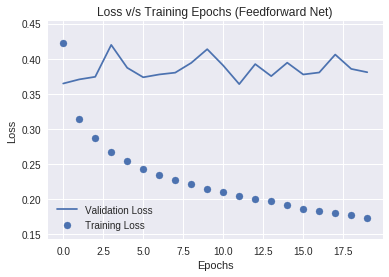

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

num_epochs = len(history.history['loss'])
ax.scatter( range(num_epochs), history.history['loss'], label='Training Loss' )
ax.plot( range(num_epochs), history.history['val_loss'], label='Validation Loss' )
ax.legend()
ax.set_title('Loss v/s Training Epochs (Feedforward Net)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

results_dir = 'results'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
filename = 'temperature_prediction_feedforwardnet.png'

fig.savefig( os.path.join(results_dir, filename) )
fig.show()

In [0]:
from keras.layers import GRU

model = Sequential()
model.add( GRU(32, input_shape=(None, data.shape[-1])) )
model.add( Dense(1) )

model.compile(optimizer='rmsprop', loss='mae')

In [29]:
history = model.fit_generator(train_gen, steps_per_epoch=1000, epochs=20, 
                              validation_data=valid_gen, validation_steps=1000)

Epoch 1/20
1000/1000 [==============================] - 205s 205ms/step - loss: 0.3114 - val_loss: 0.2815
Epoch 2/20
1000/1000 [==============================] - 203s 203ms/step - loss: 0.2911 - val_loss: 0.2796
Epoch 3/20
1000/1000 [==============================] - 203s 203ms/step - loss: 0.2793 - val_loss: 0.2811
Epoch 4/20
1000/1000 [==============================] - 203s 203ms/step - loss: 0.2696 - val_loss: 0.2896
Epoch 5/20
1000/1000 [==============================] - 203s 203ms/step - loss: 0.2595 - val_loss: 0.3010
Epoch 6/20
1000/1000 [==============================] - 203s 203ms/step - loss: 0.2500 - val_loss: 0.2969
Epoch 7/20
1000/1000 [==============================] - 202s 202ms/step - loss: 0.2431 - val_loss: 0.2983
Epoch 8/20
1000/1000 [==============================] - 202s 202ms/step - loss: 0.2363 - val_loss: 0.3060
Epoch 9/20
1000/1000 [==============================] - 203s 203ms/step - loss: 0.2304 - val_loss: 0.3127
Epoch 10/20
1000/1000 [=======================

In [0]:
filename = 'temperature_prediction_GRU.h5'
model.save_weights( os.path.join(models_dir, filename) )

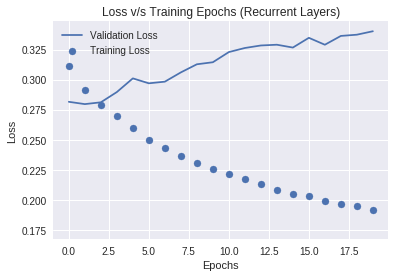

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

num_epochs = len(history.history['loss'])
ax.scatter( range(num_epochs), history.history['loss'], label='Training Loss' )
ax.plot( range(num_epochs), history.history['val_loss'], label='Validation Loss' )
ax.legend()
ax.set_title('Loss v/s Training Epochs (Recurrent Layers)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

results_dir = 'results'
filename = 'temperature_prediction_GRUs.png'

fig.savefig( os.path.join(results_dir, filename) )
fig.show()

In [32]:
# Since we are clearly observing overfitting, we should try dropout
model = Sequential()

model.add( GRU(32, dropout=0.2, recurrent_dropout=0.2, 
               input_shape=(None, data.shape[-1])) )
model.add( Dense(1) )
print(model.summary())

model.compile(optimizer='rmsprop', loss='mae')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40,
                              validation_data=valid_gen, validation_steps=500)

filename = 'temperature_prediction_GRUs_dropout.h5'
model.save_weights( os.path.join(models_dir, filename) )

Epoch 1/40
500/500 [==============================] - 119s 238ms/step - loss: 0.3516 - val_loss: 0.2882
Epoch 2/40
500/500 [==============================] - 118s 237ms/step - loss: 0.3305 - val_loss: 0.2880
Epoch 3/40
500/500 [==============================] - 118s 236ms/step - loss: 0.3263 - val_loss: 0.2832
Epoch 4/40
500/500 [==============================] - 118s 235ms/step - loss: 0.3202 - val_loss: 0.2871
Epoch 5/40
500/500 [==============================] - 118s 237ms/step - loss: 0.3180 - val_loss: 0.2863
Epoch 6/40
500/500 [==============================] - 118s 236ms/step - loss: 0.3153 - val_loss: 0.2780
Epoch 7/40
500/500 [==============================] - 118s 236ms/step - loss: 0.3139 - val_loss: 0.2787
Epoch 8/40
500/500 [==============================] - 117s 235ms/step - loss: 0.3096 - val_loss: 0.2828
Epoch 9/40
500/500 [==============================] - 118s 235ms/step - loss: 0.3098 - val_loss: 0.2805
Epoch 10/40
500/500 [==============================] - 118s 236m

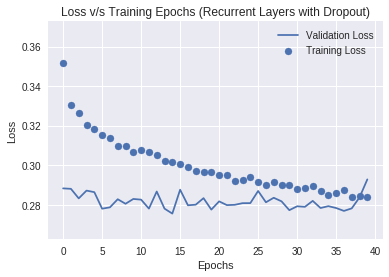

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)

num_epochs = len(history.history['loss'])
ax.scatter( range(num_epochs), history.history['loss'], label='Training Loss' )
ax.plot( range(num_epochs), history.history['val_loss'], label='Validation Loss' )
ax.legend()
ax.set_title('Loss v/s Training Epochs (Recurrent Layers with Dropout)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

results_dir = 'results'
filename = 'temperature_prediction_GRUs_with_dropout.png'

fig.savefig( os.path.join(results_dir, filename) )
fig.show()